# Full model pipeline for optimizing anchor sizes for RPN

## Overview

This notebook provides a complete pipeline for optimizing RPN anchor sizes using **GEOMETRIC COVERAGE**:
1. **Dataset Analysis** - Analyze object sizes and aspect ratios in your dataset
2. **Stride-Constrained Suggestions** - Get anchor recommendations respecting FPN constraints
3. **Optuna Optimization** - Find optimal anchors using theoretical recall 
4. **Comparison** - Compare different anchor configurations

### Key Insight
Anchor optimization should find anchors that **geometrically cover** GT boxes with high IoU.

## 0. Kaggle

In [11]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git

fatal: destination path 'isaid-instance-segmentation' already exists and is not an empty directory.


In [12]:
%cd /kaggle/working/isaid-instance-segmentation
!git pull

/kaggle/working/isaid-instance-segmentation
Your configuration specifies to merge with the ref 'refs/heads/mk'
from the remote, but no such ref was fetched.


## 1. Setup and Imports

In [13]:
import os
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Set memory optimization for CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cpu


In [14]:
# Install optuna if not available
try:
    import optuna
    print(f"Optuna version: {optuna.__version__}")
except ImportError:
    print("Installing optuna...")
    !pip install optuna
    import optuna

Optuna version: 4.6.0


In [15]:
import importlib
import datasets.isaid_dataset
import models.maskrcnn_model
import utils.overfit_test
import training.trainer
import training.transforms
import training.anchor_optimizer

importlib.reload(datasets.isaid_dataset)
importlib.reload(models.maskrcnn_model)
importlib.reload(utils.overfit_test)
importlib.reload(training.trainer)
importlib.reload(training.transforms)
importlib.reload(training.anchor_optimizer)

# Import project modules
from datasets.isaid_dataset import iSAIDDataset
from training.transforms import get_transforms
from training.anchor_optimizer import (
    AnchorConfig,
    GeometricAnchorOptimizer,  # New: uses geometric recall
    DatasetAnchorAnalyzer,
    optimize_anchors_for_dataset,
    analyze_dataset_anchors,
    compare_anchor_configs,
    generate_anchors_for_image,
    FPN_STRIDES,
)
from models.maskrcnn_model import CustomMaskRCNN, get_custom_maskrcnn

print("All modules imported successfully!")
print(f"FPN Strides: {FPN_STRIDES}")

All modules imported successfully!
FPN Strides: {'P2': 4, 'P3': 8, 'P4': 16, 'P5': 32}


## 2. Configuration

In [16]:
# Configuration
CONFIG = {
    # Dataset
    "data_root": "/kaggle/input/isaid-patches/iSAID_patches",  # Path to dataset
    "num_classes": 16,                 # 15 classes + background
    "image_size": 800,                 # Image size for training
    
    # Anchor Optimization
    "n_trials": 30,                    # Number of Optuna trials
    "num_samples": 700,                # Samples for geometric recall evaluation
    "num_analysis_samples": 7000,

    # FPN Strides (critical for anchor constraints!)
    "strides": [4, 8, 16, 32],         # P2, P3, P4, P5
    
    # Output
    "cache_path": "/kaggle/working/optimized_anchors.pt",  # Where to save optimized anchors
}

# Default stride-based anchor configuration (respects FPN constraints)
# Rule: anchor_size >= stride * 2 for effective detection
DEFAULT_ANCHORS = AnchorConfig(
    sizes=tuple((s*2, s*4) for s in CONFIG["strides"]),  # (8,16), (16,32), (32,64), (64,128)
    aspect_ratios=((0.5, 1.0, 2.0),) * 4,
)

print("Configuration loaded:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

print(f"\nDefault (stride-based) anchors:")
print(f"  Sizes: {DEFAULT_ANCHORS.sizes}")
print(f"  Ratios: {DEFAULT_ANCHORS.aspect_ratios}")
print(f"\nNote: Anchor size >= stride*2 for each FPN level!")

Configuration loaded:
  data_root: /kaggle/input/isaid-patches/iSAID_patches
  num_classes: 16
  image_size: 800
  n_trials: 30
  num_samples: 700
  num_analysis_samples: 7000
  strides: [4, 8, 16, 32]
  cache_path: /kaggle/working/optimized_anchors.pt

Default (stride-based) anchors:
  Sizes: ((8, 16), (16, 32), (32, 64), (64, 128))
  Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))

Note: Anchor size >= stride*2 for each FPN level!


## 3. Load Dataset

In [17]:
# Load datasets (without augmentation for analysis)
print("Loading datasets...")

train_dataset = iSAIDDataset(
    CONFIG["data_root"],
    split="train",
    transforms=get_transforms(train=False),
    image_size=CONFIG["image_size"],
)

val_dataset = iSAIDDataset(
    CONFIG["data_root"],
    split="val",
    transforms=get_transforms(train=False),
    image_size=CONFIG["image_size"],
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Loading datasets...
Filtered dataset: 18732 images with annotations
Filtered dataset: 6048 images with annotations
Train samples: 18732
Val samples: 6048


## 4. Dataset Analysis

First, let's analyze the object sizes and aspect ratios in the dataset to understand what anchor configurations might work best.

In [18]:
# Analyze dataset for bounding box statistics
analyzer = DatasetAnchorAnalyzer(train_dataset, num_samples=CONFIG["num_analysis_samples"])
stats = analyzer.compute_box_statistics()

print(f"\n{'='*50}")
print("Dataset Bounding Box Statistics")
print(f"{'='*50}")
print(f"Number of boxes analyzed: {len(stats['widths']):,}")
print(f"\nWidth:  min={stats['widths'].min():.1f}, max={stats['widths'].max():.1f}, mean={stats['widths'].mean():.1f}, std={stats['widths'].std():.1f}")
print(f"Height: min={stats['heights'].min():.1f}, max={stats['heights'].max():.1f}, mean={stats['heights'].mean():.1f}, std={stats['heights'].std():.1f}")
print(f"Area:   min={stats['areas'].min():.1f}, max={stats['areas'].max():.1f}, mean={stats['areas'].mean():.1f}")
print(f"Aspect Ratio: min={stats['aspect_ratios'].min():.2f}, max={stats['aspect_ratios'].max():.2f}, mean={stats['aspect_ratios'].mean():.2f}")

Analyzing 7000 samples for anchor statistics...


Analyzing boxes:   0%|          | 0/7000 [00:00<?, ?it/s]


Dataset Bounding Box Statistics
Number of boxes analyzed: 270,636

Width:  min=1.0, max=800.0, mean=24.1, std=37.0
Height: min=1.0, max=800.0, mean=24.8, std=39.8
Area:   min=6.0, max=640000.0, mean=1692.8
Aspect Ratio: min=0.01, max=44.67, mean=1.15


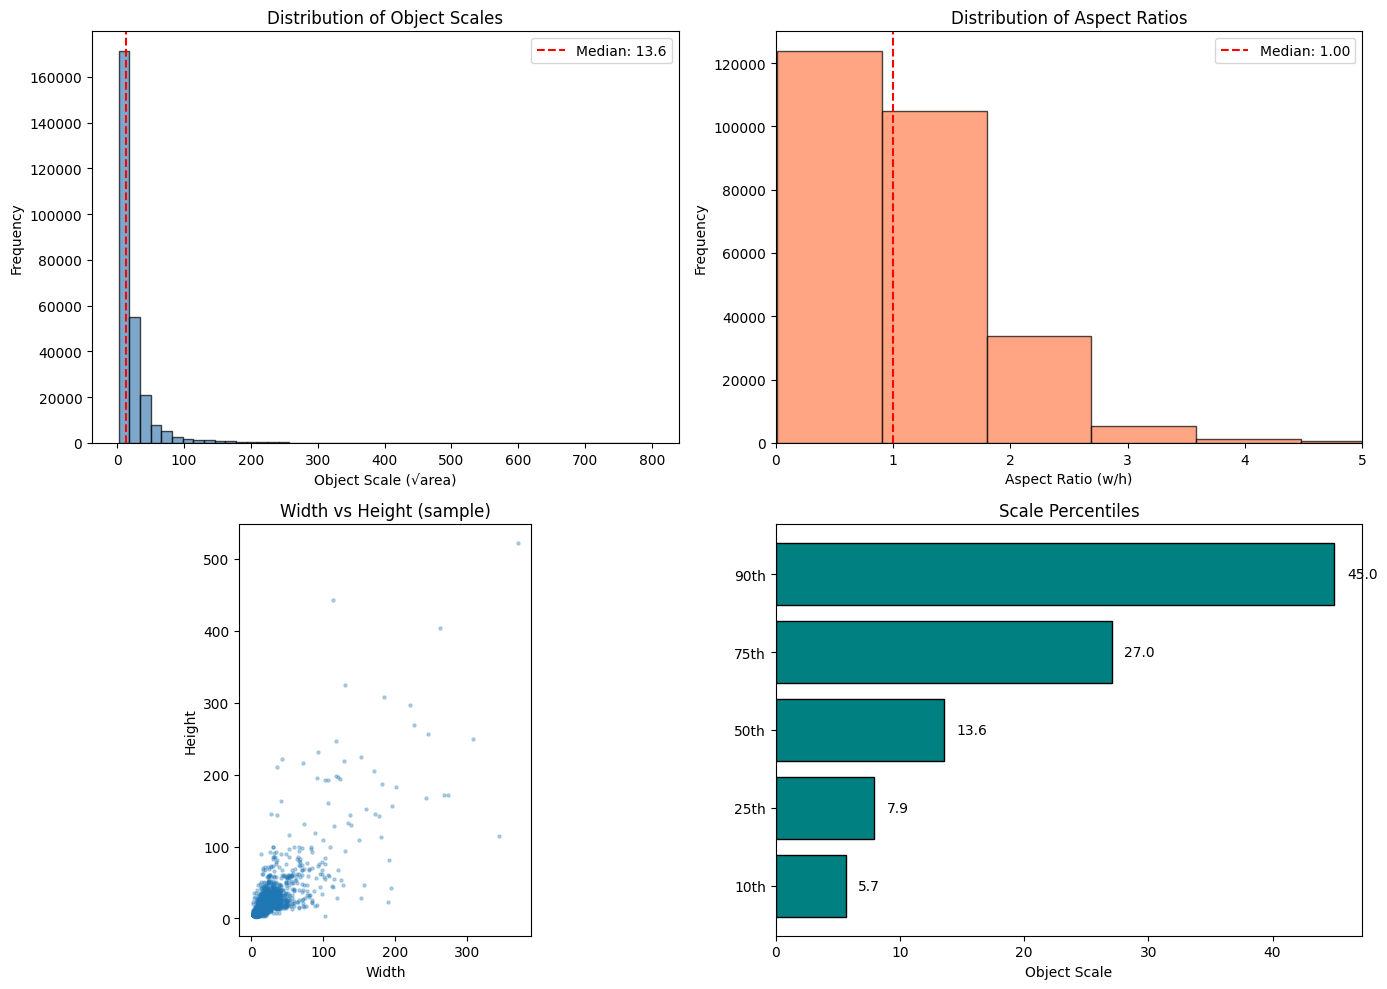


Scale percentiles (useful for anchor sizes):
  10th percentile: 5.7
  20th percentile: 7.3
  30th percentile: 8.5
  50th percentile: 13.6
  70th percentile: 22.9
  80th percentile: 31.0
  90th percentile: 45.0


In [19]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Object scales (sqrt of area)
scales = np.sqrt(stats['areas'])
axes[0, 0].hist(scales, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.median(scales), color='red', linestyle='--', label=f'Median: {np.median(scales):.1f}')
axes[0, 0].set_xlabel('Object Scale (√area)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Object Scales')
axes[0, 0].legend()

# Aspect ratios
axes[0, 1].hist(stats['aspect_ratios'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(np.median(stats['aspect_ratios']), color='red', linestyle='--', 
                   label=f'Median: {np.median(stats["aspect_ratios"]):.2f}')
axes[0, 1].set_xlabel('Aspect Ratio (w/h)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Aspect Ratios')
axes[0, 1].set_xlim(0, 5)
axes[0, 1].legend()

# Width vs Height scatter
sample_idx = np.random.choice(len(stats['widths']), min(2000, len(stats['widths'])), replace=False)
axes[1, 0].scatter(stats['widths'][sample_idx], stats['heights'][sample_idx], alpha=0.3, s=5)
axes[1, 0].set_xlabel('Width')
axes[1, 0].set_ylabel('Height')
axes[1, 0].set_title('Width vs Height (sample)')
axes[1, 0].set_aspect('equal')

# Scale percentiles (for anchor size selection)
percentiles = [10, 25, 50, 75, 90]
scale_percentiles = np.percentile(scales, percentiles)
axes[1, 1].barh(range(len(percentiles)), scale_percentiles, color='teal', edgecolor='black')
axes[1, 1].set_yticks(range(len(percentiles)))
axes[1, 1].set_yticklabels([f'{p}th' for p in percentiles])
axes[1, 1].set_xlabel('Object Scale')
axes[1, 1].set_title('Scale Percentiles')
for i, v in enumerate(scale_percentiles):
    axes[1, 1].text(v + 1, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()

print("\nScale percentiles (useful for anchor sizes):")
for p in [10, 20, 30, 50, 70, 80, 90]:
    print(f"  {p}th percentile: {np.percentile(scales, p):.1f}")

## 5. Data-Driven Anchor Suggestions

Get initial anchor recommendations based on dataset statistics (without Optuna optimization).

In [20]:
# Get stride-constrained suggestions based on data
suggested_sizes = analyzer.suggest_anchor_sizes_with_stride_constraints(
    strides=CONFIG["strides"]
)
suggested_ratios = analyzer.suggest_aspect_ratios(num_ratios=3)

print(f"\n{'='*60}")
print("STRIDE-CONSTRAINED Anchor Suggestions")
print(f"{'='*60}")
print(f"\nFPN Level | Stride | Min Valid | Suggested Sizes")
print("-" * 60)
for i, (stride, sizes) in enumerate(zip(CONFIG["strides"], suggested_sizes)):
    min_valid = stride * 2
    print(f"   P{i+2}    |   {stride:2d}   |    {min_valid:3d}    | {sizes}")

print(f"\nSuggested aspect ratios: {suggested_ratios}")

print(f"\n{'='*60}")
print("Comparison")
print(f"{'='*60}")
print(f"Default sizes:    {DEFAULT_ANCHORS.sizes}")
print(f"Suggested sizes:  {suggested_sizes}")


Object scale distribution:
  10th percentile: 5.7 px
  25th percentile: 7.9 px
  50th percentile: 13.6 px
  75th percentile: 27.0 px
  90th percentile: 45.0 px
  95th percentile: 70.7 px

Stride-constrained anchor sizes: [(8, 12), (16, 24), (32, 48), (64, 96)]
Suggested aspect ratios based on data: (np.float64(0.59), np.float64(1.0), np.float64(1.62))

STRIDE-CONSTRAINED Anchor Suggestions

FPN Level | Stride | Min Valid | Suggested Sizes
------------------------------------------------------------
   P2    |    4   |      8    | (8, 12)
   P3    |    8   |     16    | (16, 24)
   P4    |   16   |     32    | (32, 48)
   P5    |   32   |     64    | (64, 96)

Suggested aspect ratios: (np.float64(0.59), np.float64(1.0), np.float64(1.62))

Comparison
Default sizes:    ((8, 16), (16, 32), (32, 64), (64, 128))
Suggested sizes:  ((8, 12), (16, 24), (32, 48), (64, 96))


## 6. Geometric Anchor Optimization

Run Optuna optimization using **geometric recall** (theoretical IoU coverage).

In [21]:
geo_optimizer = GeometricAnchorOptimizer(
    dataset=train_dataset,
    image_size=(CONFIG["image_size"], CONFIG["image_size"]),
    strides=CONFIG["strides"],
    base_aspect_ratios=(0.5, 1.0, 2.0),
    num_samples=CONFIG["num_samples"],
)

print("Geometric Optimizer initialized!")
print(f"Cached {geo_optimizer.total_gt_boxes} GT boxes for fast evaluation")
print(f"Suggested ratios from data: {geo_optimizer.suggested_ratios}")

Analyzing 700 samples for anchor statistics...


Analyzing boxes:   0%|          | 0/700 [00:00<?, ?it/s]

Suggested aspect ratios based on data: (np.float64(0.57), np.float64(0.93), np.float64(1.5))
Caching GT boxes from 700 samples...


Caching GT boxes:   0%|          | 0/700 [00:00<?, ?it/s]

Cached 25545 GT boxes from 700 images
Geometric Optimizer initialized!
Cached 25545 GT boxes for fast evaluation
Suggested ratios from data: (np.float64(0.57), np.float64(0.93), np.float64(1.5))


In [22]:
print(f"Starting GEOMETRIC optimization with {CONFIG['n_trials']} trials...")

best_config = geo_optimizer.optimize(
    n_trials=CONFIG["n_trials"],
    study_name="geometric_anchor_optimization",
)

Starting GEOMETRIC optimization with 30 trials...
Geometric Anchor Optimization (No Training Required)
Image size: (800, 800)
FPN strides: [4, 8, 16, 32]
Evaluating 700 images, 25545 GT boxes
Running 30 trials...


[I 2026-01-26 18:50:29,950] A new study created in memory with name: geometric_anchor_optimization



Baseline (stride-based default) anchors:
  Sizes: ((8, 16), (16, 32), (32, 64), (64, 128))
  Recalls: {'recall@0.5': 0.8395380700724212, 'recall@0.7': 0.3029555686044236}


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-26 18:54:33,903] Trial 0 finished with value: 0.2739479350166373 and parameters: {'size_l0_1': 28, 'size_l0_2': 64, 'size_l1_1': 96, 'size_l1_2': 80, 'size_l2_1': 64, 'size_l2_2': 64, 'size_l3_1': 64, 'size_l3_2': 448, 'optimize_ratios': False}. Best is trial 0 with value: 0.2739479350166373.
[I 2026-01-26 18:58:13,082] Trial 1 finished with value: 0.36151105891563906 and parameters: {'size_l0_1': 8, 'size_l0_2': 64, 'size_l1_1': 112, 'size_l1_2': 40, 'size_l2_1': 64, 'size_l2_2': 64, 'size_l3_1': 192, 'size_l3_2': 288, 'optimize_ratios': True, 'ratio_1': 0.6000000000000001, 'ratio_2': 0.8, 'ratio_3': 2.0}. Best is trial 1 with value: 0.36151105891563906.
[I 2026-01-26 19:01:57,807] Trial 2 finished with value: 0.2857584654531219 and parameters: {'size_l0_1': 28, 'size_l0_2': 32, 'size_l1_1': 104, 'size_l1_2': 32, 'size_l2_1': 144, 'size_l2_2': 160, 'size_l3_1': 64, 'size_l3_2': 352, 'optimize_ratios': True, 'ratio_1': 0.8, 'ratio_2': 1.2, 'ratio_3': 2.75}. Best is trial 1 w

## 7. Compare Anchor Configurations

Compare geometric recall for different anchor configurations.
This shows the **theoretical maximum recall** each configuration can achieve.

In [23]:
# Compare multiple anchor configurations using geometric recall
configs_to_compare = {
    "Stride Adjusted": DEFAULT_ANCHORS,
    "Opt 1": AnchorConfig(
        sizes=((12, 24), (64, 96), (48, 144), (64, 480)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4,
    ),
    "Opt 2": AnchorConfig(
        sizes=((12, 52), (24, 56), (176, 224), (64, 192)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4,
    ),
    "Opt 3": AnchorConfig(
        sizes=((8, 44), (16, 56), (144, 208), (96, 192)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4,
    ),
    "Initial guess": AnchorConfig(
        sizes=((16, 24), (32, 48), (64, 96), (128, 192)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4,
    ),
    "Data-suggested": AnchorConfig(
        sizes=((8, 12), (16, 24), (32, 48), (64, 96)),
        aspect_ratios=((np.float64(0.6), np.float64(1.0), np.float64(1.67)),) * 4,
    ),
    "Data-suggested (default ratios)": AnchorConfig(
        sizes=((8, 12), (16, 24), (32, 48), (64, 96)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 4
    ),
}

print("=" * 60)
print("GEOMETRIC RECALL COMPARISON")
print("(Theoretical maximum recall - no training involved)")
print("=" * 60)

comparison_results = compare_anchor_configs(
    dataset=train_dataset,
    configs=configs_to_compare,
    image_size=(CONFIG["image_size"], CONFIG["image_size"]),
    num_samples=CONFIG["num_samples"],
)

GEOMETRIC RECALL COMPARISON
(Theoretical maximum recall - no training involved)
Analyzing 700 samples for anchor statistics...


Analyzing boxes:   0%|          | 0/700 [00:00<?, ?it/s]

Suggested aspect ratios based on data: (np.float64(0.57), np.float64(0.99), np.float64(1.71))
Caching GT boxes from 700 samples...


Caching GT boxes:   0%|          | 0/700 [00:00<?, ?it/s]

Cached 28786 GT boxes from 700 images

Evaluating: Stride Adjusted
  Sizes: ((8, 16), (16, 32), (32, 64), (64, 128))
  Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  Recalls: {'recall@0.5': 0.8397484888487459, 'recall@0.7': 0.29559508094212467, 'recall@0.75': 0.1577850343917182}

Evaluating: Opt 1
  Sizes: ((12, 24), (64, 96), (48, 144), (64, 480))
  Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  Recalls: {'recall@0.5': 0.7154172167025638, 'recall@0.7': 0.20054887792676995, 'recall@0.75': 0.11509066907524491}

Evaluating: Opt 2
  Sizes: ((12, 52), (24, 56), (176, 224), (64, 192))
  Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  Recalls: {'recall@0.5': 0.6749461543806017, 'recall@0.7': 0.14712012783992218, 'recall@0.75': 0.07927464739804072}

Evaluating: Opt 3
  Sizes: ((8, 44), (16, 56), (144, 208), (96, 192))
  Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  R

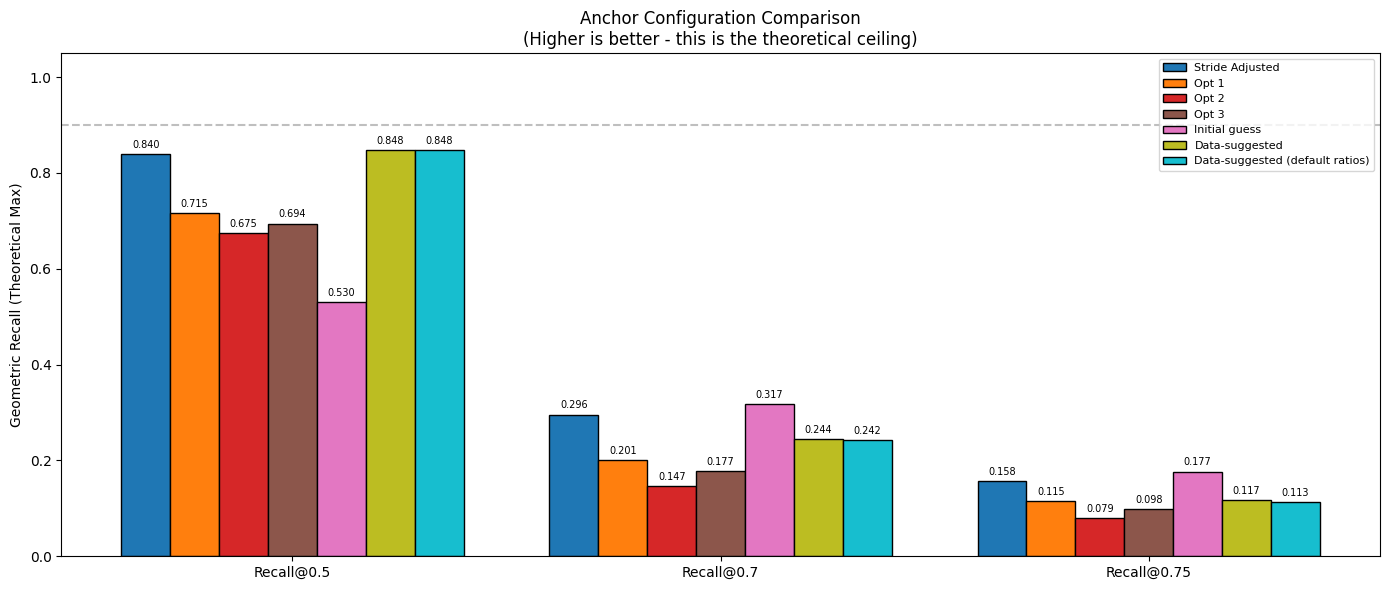


SUMMARY: Geometric Recall Comparison

Stride Adjusted:
  recall@0.5: 0.8397
  recall@0.7: 0.2956
  recall@0.75: 0.1578

Opt 1:
  recall@0.5: 0.7154
  recall@0.7: 0.2005
  recall@0.75: 0.1151

Opt 2:
  recall@0.5: 0.6749
  recall@0.7: 0.1471
  recall@0.75: 0.0793

Opt 3:
  recall@0.5: 0.6942
  recall@0.7: 0.1772
  recall@0.75: 0.0978

Initial guess:
  recall@0.5: 0.5303
  recall@0.7: 0.3170
  recall@0.75: 0.1767

Data-suggested:
  recall@0.5: 0.8477
  recall@0.7: 0.2444
  recall@0.75: 0.1169

Data-suggested (default ratios):
  recall@0.5: 0.8478
  recall@0.7: 0.2417
  recall@0.75: 0.1127


In [24]:
# Visualize comparison - DYNAMIC for any number of configs
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(max(12, len(configs_to_compare) * 2), 6))

config_names = list(comparison_results.keys())
metrics = ['recall@0.5', 'recall@0.7', 'recall@0.75']
x = np.arange(len(metrics))
n_configs = len(config_names)
width = 0.8 / n_configs  # Dynamic width based on number of configs

# Generate colors dynamically
colors = cm.tab10(np.linspace(0, 1, n_configs))

for i, (name, results) in enumerate(comparison_results.items()):
    vals = [results.get(m, 0) for m in metrics]
    offset = (i - n_configs/2 + 0.5) * width
    bars = ax.bar(x + offset, vals, width, label=name, color=colors[i], edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)

ax.set_ylabel('Geometric Recall (Theoretical Max)')
ax.set_title('Anchor Configuration Comparison\n(Higher is better - this is the theoretical ceiling)')
ax.set_xticks(x)
ax.set_xticklabels(['Recall@0.5', 'Recall@0.7', 'Recall@0.75'])
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0, 1.05)
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("SUMMARY: Geometric Recall Comparison")
print(f"{'='*60}")
for name, results in comparison_results.items():
    print(f"\n{name}:")
    for m, v in results.items():
        print(f"  {m}: {v:.4f}")

## 8. Visualize Anchor Coverage

See how anchors cover the object size distribution.

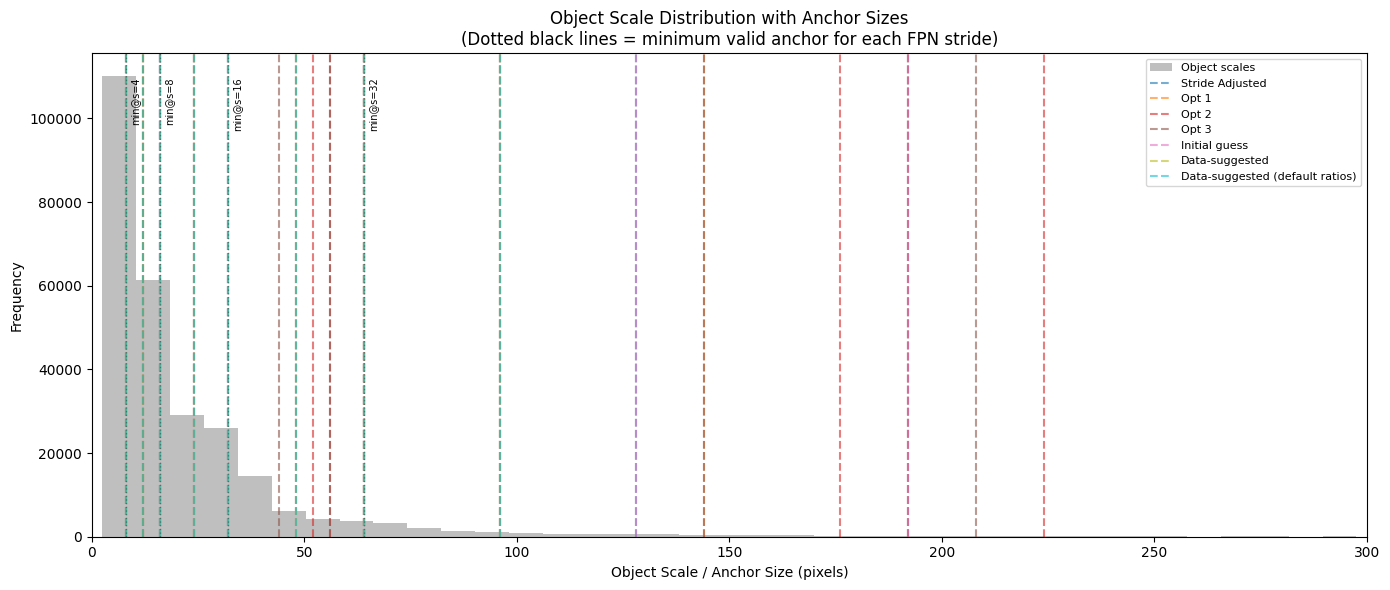


ANCHOR CONFIGURATION DETAILS
FPN Level | Stride | Min Valid | Stride Adjusted |      Opt 1      |      Opt 2      |      Opt 3      |  Initial guess  | Data-suggested  | Data-suggested 
------------------------------------------------------------------------------------------------------------------------------------------------------------
   P2    |    4   |      8    |     (8, 16)     |    (12, 24)     |    (12, 52)     |     (8, 44)     |    (16, 24)     |     (8, 12)     |     (8, 12)    
   P3    |    8   |     16    |    (16, 32)     |    (64, 96)     |    (24, 56)     |    (16, 56)     |    (32, 48)     |    (16, 24)     |    (16, 24)    
   P4    |   16   |     32    |    (32, 64)     |    (48, 144)    |   (176, 224)    |   (144, 208)    |    (64, 96)     |    (32, 48)     |    (32, 48)    
   P5    |   32   |     64    |    (64, 128)    |    (64, 480)    |    (64, 192)    |    (96, 192)    |   (128, 192)    |    (64, 96)     |    (64, 96)    


In [25]:
# Visualize anchor sizes vs object scale distribution - DYNAMIC
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(14, 6))

# Plot object scale histogram
scales = np.sqrt(stats['areas'])
ax.hist(scales, bins=100, alpha=0.5, color='gray', edgecolor='none', label='Object scales')

# Generate colors dynamically for all configs
config_names = list(configs_to_compare.keys())
n_configs = len(config_names)
colors = cm.tab10(np.linspace(0, 1, n_configs))
color_map = {name: colors[i] for i, name in enumerate(config_names)}

# Plot anchor sizes for each configuration
for name, config in configs_to_compare.items():
    color = color_map[name]
    for level_idx, sizes in enumerate(config.sizes):
        for j, size in enumerate(sizes):
            # Only add label once per config
            label = name if level_idx == 0 and j == 0 else None
            ax.axvline(size, color=color, alpha=0.6, linestyle='--', linewidth=1.5, label=label)

# Add FPN stride markers
for stride in CONFIG["strides"]:
    min_anchor = stride * 2
    ax.axvline(min_anchor, color='black', alpha=0.3, linestyle=':', linewidth=1)
    ax.text(min_anchor + 1, ax.get_ylim()[1] * 0.95, f'min@s={stride}', fontsize=7, rotation=90, va='top')

ax.set_xlabel('Object Scale / Anchor Size (pixels)')
ax.set_ylabel('Frequency')
ax.set_title('Object Scale Distribution with Anchor Sizes\n(Dotted black lines = minimum valid anchor for each FPN stride)')
ax.legend(loc='upper right', fontsize=8)
ax.set_xlim(0, 300)

plt.tight_layout()
plt.show()

# Show all configurations clearly - DYNAMIC
print(f"\n{'='*70}")
print("ANCHOR CONFIGURATION DETAILS")
print(f"{'='*70}")

# Build header dynamically
header = "FPN Level | Stride | Min Valid"
for name in config_names:
    header += f" | {name[:15]:^15}"
print(header)
print("-" * len(header))

for i, stride in enumerate(CONFIG["strides"]):
    min_valid = stride * 2
    row = f"   P{i+2}    |   {stride:2d}   |    {min_valid:3d}   "
    for name in config_names:
        config = configs_to_compare[name]
        sizes = config.sizes[i] if i < len(config.sizes) else "N/A"
        row += f" | {str(sizes):^15}"
    print(row)

In [26]:
# Cleanup
del train_dataset, val_dataset, analyzer, geo_optimizer
gc.collect()
torch.cuda.empty_cache()

print("Cleanup complete!")

Cleanup complete!
